<a href="https://colab.research.google.com/github/shivamsharma00/shivamsharma00/blob/main/CNN_fashion_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U tensorflow_datasets

# **Install and import dependencies**

We'll need Tensorflow Datasets, an API that simplifies downloading and accessing datasets, and provide several sample datasets to work with. 

In [ ]:
from __future__ import absolute_import, division, print_function

# Import Tensorflow and Tensorflow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# Helper libraries
import math 
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)



2.7.0


# **Loading the datasets**


In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_data, test_data = dataset['train'], dataset['test']

In [ ]:
# loading the label for human readable results
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# **Explore the data**
Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set.

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of training examples: {}'.format(num_train_examples))
print('Number of test examples:     {}'.format(num_test_examples))


Number of training examples: 60000
Number of test examples:     10000


# **Preprocess the data**
The value of each pixel in the image data is an integer is in the range [0, 255]. For the model to work properly, these values need to be normalized to the range [0, 1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.


In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train and test datasets.
train_data = train_data.map(normalize)
test_data = test_data.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_data =  train_data.cache()
test_data  =  test_data.cache()

### Explore the processed data

Let's plot an image to see what it looks like.

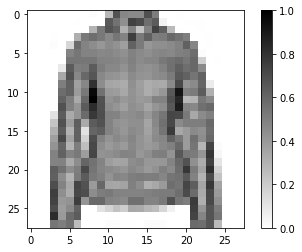

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_data.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

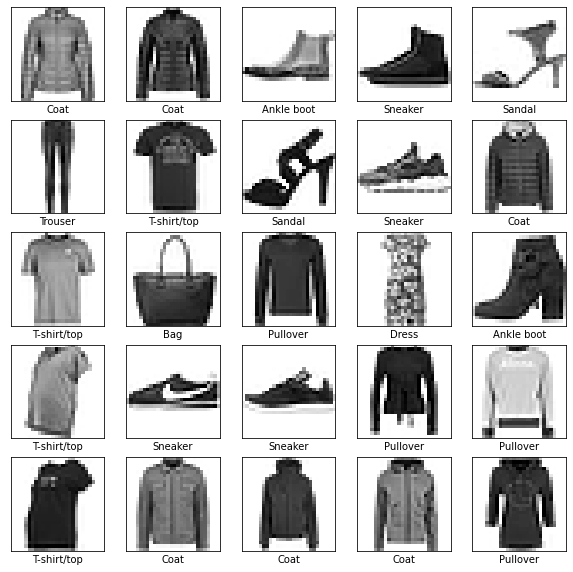

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_data.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# **Build the model**


---

## Setup the layers

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                                                    input_shape=(28, 28, 1)),
                             tf.keras.layers.MaxPooling2D((2, 2), strides=2),
                             tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
                             tf.keras.layers.MaxPooling2D((2, 2), strides=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)
                             ])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

> Note: Using `softmax` activation and `SparseCategoricalCrossentropy()` has issues and which are patched by the `tf.keras` model. A safer approach, in general, is to use a linear output (no activation function) with `SparseCategoricalCrossentropy(from_logits=True)`.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.


In [ ]:
BATCH_SIZE = 32
train_data = train_data.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_data = test_data.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_data, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 19s 6ms/step - loss: 0.4040 - accuracy: 0.8555
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2550 - accuracy: 0.9070
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2163 - accuracy: 0.9201
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1791 - accuracy: 0.9342
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1539 - accuracy: 0.9427
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1305 - accuracy: 0.9514
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1132 - accuracy: 0.9587
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0931 - accuracy: 0.9658
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0801 - accuracy: 0.9715
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - l

## Evaluate accuracy
We will compare how the model performs on the test dataset. Use all example we have in the test dataset to assess accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3414 - accuracy: 0.9192
Accuracy on test dataset: 0.9192000031471252


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [ ]:
for test_images, test_labels in test_data.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [ ]:
predictions.shape


(32, 10)

Here, the model has predicted the probability of each label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
predictions[0]

array([5.02330261e-11, 5.42246673e-12, 1.29184730e-06, 1.32238386e-14,
       9.99833465e-01, 2.08600359e-11, 1.65180172e-04, 1.52204367e-13,
       1.09254155e-14, 1.21760310e-10], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [ ]:
np.argmax(predictions[0])

4

So the model is usually most confident that this image is a Shirt, or `class_names[6]`. Let's check the label:

In [ ]:
class_names[6]

'Shirt'

We can graph this to look at the full set of 10 class predictions

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

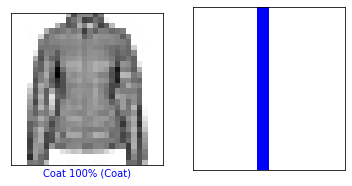

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

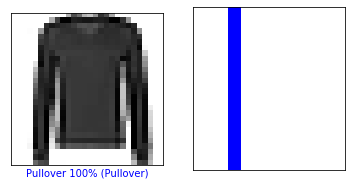

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

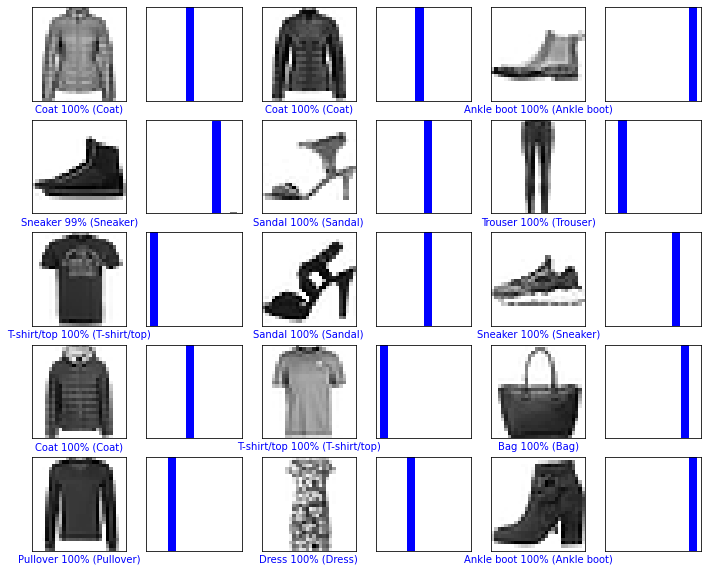

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 

In [ ]:

# Grab an image from the test dataset
img = test_images[0]

print(img.shape)


(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

[[5.02329289e-11 5.42244591e-12 1.29184969e-06 1.32238386e-14
  9.99833465e-01 2.08599943e-11 1.65180798e-04 1.52204367e-13
  1.09254155e-14 1.21760310e-10]]


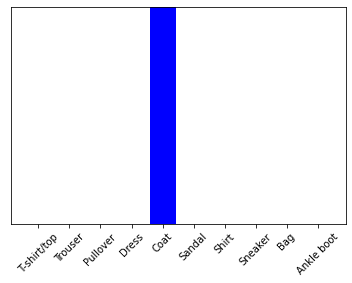

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [ ]:
np.argmax(predictions_single[0])

4

And, as before, the model predicts a label of 6 (shirt).